In [1]:
import numpy as np
import pandas as pd
import multiprocessing

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline
%matplotlib inline

%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 800)

Loading BokehJS ...

## Overstock-SupplyChain-Understock (OSU) Correction

In [ ]:
# # Wall time: 3min 4s

# dat = pd.read_csv('Transaction.csv', low_memory = False) # *** DATA ***

# dat['consumer_order_date'] = pd.to_datetime(dat['consumer_order_date'])

# # # Transaction subset: SS19
# dat = dat[['consumer_order_date', 'article_number', 'gross_demand_quantity', 'net_qty', 'Sale', 'season']]
# dat = dat[dat['season'] == 'SS19']

# dat_SS20_range = pd.read_csv('dat_SS20_range.csv') # *** DATA ***
# SS20_range = dat_SS20_range['Article Number'].unique()
# dat = dat[[(a in SS20_range) for a in dat['article_number']]]

In [2]:
# dat.to_csv('dat_SS20range.csv') # -----> DATA SAVE POINT <------

dat = pd.read_csv('dat_SS20range.csv', low_memory=False, index_col = 0) # *** DATA ***
dat['consumer_order_date'] = pd.to_datetime(dat['consumer_order_date'])

# Subset to non-clearance transactions only --- change here for David/Mike's request
dat = dat[dat['Sale'] == 0]

# 'aggregate' to weekly sums by article for buy_availability merge and adjustment
dat.set_index('consumer_order_date', inplace = True)

dat = dat[['article_number', 'gross_demand_quantity', 'net_qty']].groupby(['article_number']).resample('W').sum()
dat.reset_index(inplace=True)

# Add 'week' and 'year' for merging with stock (buy_availability) data (b/c min_date_of_week)
dat['week'] = [t.week for t in dat['consumer_order_date']]
dat['year'] = [t.year for t in dat['consumer_order_date']]

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
# Stock data
stock = pd.read_csv('Stock.csv', low_memory=False, index_col = 0) # *** DATA ***

stock['year'] = [str(x)[0:4] for x in stock['week_id']]
stock['week'] = [str(x)[4:6] for x in stock['week_id']]
stock.drop('week_id', axis = 1, inplace = True)

# Tidy
stock.reset_index(inplace = True)
stock.drop(['avg(ecom_available_stock)', 'avg(size_availability)'], axis = 1, inplace = True)
stock.rename(columns = {'avg(buy_availability)': 'buy_availability'}, inplace = True)

stock = stock[(stock['year'] != '2016') & (stock['year'] != '2017')]

stock[['year', 'week']] = stock[['year', 'week']].astype('int64', copy = False)

# Merge weekly demand df and buy_availability df -- for understock correction
dat = pd.merge(dat, stock, 
               left_on = ['article_number', 'year', 'week'], 
               right_on = ['article_number', 'year', 'week'], 
               how = 'left')

dat.fillna(1, inplace=True) # Assume buy_availability = 1

# dat[[x in ['DQ2136', 'DQ3089', 'DU0367', 'DU0369', 'DU0382', 'EE9806', 'EE9809', 'G28417'] for x in dat['article_number']]] 
# ------- Joerian: buy_availability DNE for these articles, for some reason -------

In [5]:
# ----- Calculate *observed* full season gross_demand_quantity per article -----
# --> Important to reload, b/c existing environment dat is without clearance transactions

dat_season = pd.read_csv('dat_SS20range.csv', low_memory=False, index_col = 0) # *** DATA ***
dat_season = pd.DataFrame(dat_season.groupby(['article_number'])['gross_demand_quantity', 'net_qty'].sum()) # THIS RIGHT???
dat_season.rename(columns = {'gross_demand_quantity':'season_gross_demand_quantity',
                             'net_qty':'season_net_qty'}, inplace = True)


In [ ]:
# WEEKLY averages for articles when buy_availability > 0.35
dat_stocked = pd.DataFrame(
    dat[dat['buy_availability'] > 0.35].
    groupby(['article_number'])['gross_demand_quantity', 'net_qty'].
    mean())

# {'604433', '620635', 'BQ1935', 'BQ2001', 'BS0980', 'CV4000', 'CY8772', 'G27026'}
# These articles have ZERO weeks with: (1) buy_availability > 0.35   ***AND***   (2) gross_demand_quantity > 0

dat_stocked.rename(columns = {'gross_demand_quantity':'corrected_weekly_avg_gross_demand_quantity',
                             'net_qty': 'corrected_weekly_avg_net_qty'}, inplace= True)

# Extend to full season (26 weeks) to estimate full season demand
dat_stocked['corrected_gross_demand_quantity'] = 26*dat_stocked['corrected_weekly_avg_gross_demand_quantity'] 
dat_stocked['corrected_net_qty'] = 26*dat_stocked['corrected_weekly_avg_net_qty'] 


dat_season = pd.merge(dat_season, dat_stocked, left_index=True, right_index=True, how = 'outer')
dat_season.drop(['corrected_weekly_avg_gross_demand_quantity', 'corrected_weekly_avg_net_qty'], inplace=True, axis = 1)

preds = (pd.DataFrame(pd.read_csv('Buyers predictions.csv', low_memory=False, index_col = 0))
         [['season', 'ecom_marketing_forecast']].
         reset_index().
         dropna()
        )

preds = preds[preds['season'] == 'SS19']

dat_season['corrected_gross_demand_quantity'] = np.where(
    dat_season['corrected_gross_demand_quantity'].isna(),
    dat_season['season_gross_demand_quantity'],
    dat_season['corrected_gross_demand_quantity']
)

dat_season['corrected_net_qty'] = np.where(
    dat_season['corrected_net_qty'].isna(),
    dat_season['season_net_qty'],
    dat_season['corrected_net_qty']
)

In [ ]:
dat_season = pd.merge(
    dat_season, preds, 
    left_index = True,
    right_on = 'article', 
    how = 'left').round()

dat_season = dat_season[['article', 'season_gross_demand_quantity', 'season_net_qty',
                         'corrected_gross_demand_quantity', 'corrected_net_qty', 'ecom_marketing_forecast']]

dat_season = dat_season[(dat_season['season_gross_demand_quantity'] > 90) &
                        (dat_season['season_net_qty'] > 90)]

dat_season['DAA_SS20_gross_prediction'] = dat_season['corrected_gross_demand_quantity']*1.1
dat_season['DAA_SS20_net_prediction'] = dat_season['corrected_net_qty']*1.1

### Make pretty

In [ ]:
# Rename, reorder
dat_season.rename(columns = {
    'article': 'Article Number',
    'season_gross_demand_quantity': 'SS19 Demand',
    'season_net_qty': 'SS19 Net Qty',
    'corrected_gross_demand_quantity': 'SS19 Corrected Demand',
    'corrected_net_qty': 'SS19 Corrected Net Qty',
    'ecom_marketing_forecast': 'SS19 eCom Forecast',
    'DAA_SS20_gross_prediction': 'Analytics SS20 Gross Forecast',
    'DAA_SS20_net_prediction': 'Analytics SS20 Net Sales Forecast'
                            }, inplace = True)

dat_season = dat_season[['Article Number', 
                         'SS19 eCom Forecast', 
                         'SS19 Net Qty', 
                         'SS19 Corrected Net Qty', 
                         'Analytics SS20 Net Sales Forecast']]

In [6]:
# dat_season.to_csv('dat_season.csv')
dat_season = pd.read_csv('dat_season.csv', low_memory=False, index_col = 0) 

In [7]:
dat_season.head()

,Article Number,SS19 eCom Forecast,SS19 Net Qty,SS19 Corrected Net Qty,Analytics SS20 Net Sales Forecast
6,011040,600.0,108.0,117.0,128.7
14,015110,800.0,689.0,746.0,820.6
21,019000,2000.0,1096.0,1187.0,1305.7
29,019228,500.0,379.0,410.0,451.0
36,019310,500.0,243.0,263.0,289.3


In [5]:
ils1 = pd.read_csv('ils1.csv')

In [6]:
forecasts = (pd.merge(dat_season, ils1[['article_no', 'article_manager', 'quantity', 'retail_price']], 
                      left_on = 'Article Number', right_on = 'article_no', how = 'left').
             set_index('Article Number').
             drop('article_no', axis = 1).
             rename(columns = {'quantity': 'eCom SS20 ILS1 Buy',
                              'SS19 Demand': 'SS19 Gross',
                              'SS19 Corrected Demand': 'SS19 Corrected Gross',
                              'SS19 eCom Forecast': 'eCom SS19 Buy' , 
                              'SS19 Net': 'SS19 Net Qty'})
            )

In [7]:
# ---- Add cost ----
cost_price = pd.read_csv('Cost Price.csv', low_memory=False, index_col = 0)
cost_price.rename(columns = {'avg(cost_of_sales)': 'cost'}, inplace = True)
cost_price = pd.DataFrame(cost_price['cost'].groupby(cost_price.index).mean()).round()

forecasts = pd.merge(forecasts, cost_price, left_index=True, right_index = True, how = 'left')

# ---- add forecasts' difference ----
# diff_gross = forecasts['eCom SS20 ILS1 Buy'] - forecasts['Analytics SS20 Gross Forecast']
diff_net = forecasts['eCom SS20 ILS1 Buy'] - forecasts['Analytics SS20 Net Sales Forecast']

# forecasts['Gross Difference-Cost'] = np.where(
#         diff_gross > 0, 
#         diff_gross*forecasts['cost'],
#         diff_gross*(-1)*(forecasts['retail_price'] - forecasts['cost'])
#     )

forecasts['Net Difference-Cost'] = np.where(
        diff_net > 0, 
        diff_net*forecasts['cost'],
        diff_net*(-1)*(forecasts['retail_price'] - forecasts['cost'])
    )

# ---- Sort by cost of difference ----
forecasts.sort_values('Net Difference-Cost', ascending = False, inplace = True)

In [9]:
dat.drop(['plant', 'warehouse'], axis = 1, inplace=True)

dat.buy_availability = dat.buy_availability.round(2)

dat.drop_duplicates(['article_number', 'consumer_order_date'], inplace = True)

dat[dat.duplicated()]

In [34]:
%whos DataFrame Series

Variable     Type         Data/Info
-----------------------------------
cost_price   DataFrame                     cost\nar<...>n[76715 rows x 1 columns]
d            DataFrame         article_number consu<...> 2019              0.90  
dat          DataFrame          article_number cons<...>n[15430 rows x 7 columns]
dat_season   DataFrame           Article Number  SS<...>                  137.5  
diff_net     Series       Article Number\n011040   <...>    -22.5\ndtype: float64
forecasts    DataFrame                    eCom SS19<...>.0               14.500  
ils1         DataFrame                 article_no  <...>[13930 rows x 10 columns]
pivoted      DataFrame    article_number       B965<...>19-05-12             0.90
pivoted2     DataFrame    article_number       B965<...>19-05-12             81.0
stock        DataFrame            article_number  b<...>5087830 rows x 6 columns]


In [39]:
ils1.head()

,article_no,article_manager,product_div,bus_seg,retail_price,product_group,product_type,category,quantity,max_revenue
0,453686,Kristina Linnemeyer,FOOTWEAR,OUTDOOR FTW ADIDAS,1.0,SHOES,SHOES - LOW (NON FOOTBALL),OUTDOOR,0.0,0.0
1,453690,Kristina Linnemeyer,FOOTWEAR,TRAINING FTW MEN ADIDAS,1.0,SHOES,SHOES - LOW (NON FOOTBALL),TRAINING,0.0,0.0
2,DZ0792,Kristina Linnemeyer,APPAREL,OUTDOOR APP ADIDAS,170.0,JACKETS,JACKET (DOWN),OUTDOOR,66.0,11220.0
3,FJ2501,Kristina Linnemeyer,HARDWARE,TRAINING/ATHLETICS ACC HW ADIDAS,180.0,BAGS,BACKPACK,TRAINING,24.0,4320.0
4,FP8485,Kristina Linnemeyer,HARDWARE,TRAINING/ATHLETICS ACC HW ADIDAS,70.0,BAGS,WAISTBAG,TRAINING,24.0,1680.0


## Plots

,eCom SS19 Buy,SS19 Net Qty,SS19 Corrected Net Qty,Analytics SS20 Net Sales Forecast,article_manager,eCom SS20 ILS1 Buy,retail_price,cost,Net Difference-Cost
Article Number,,,,,,,,,
B96578,1600.0,3601.0,4989.0,5488.0,Ksenia Kotlyarova,5265.0,60.0,13.0,10476.0


,article_number,consumer_order_date,gross_demand_quantity,net_qty,week,year,buy_availability
3828,B96578,2018-12-02,1.0,0.0,48,2018,0.01
3830,B96578,2018-12-09,21.0,17.0,49,2018,0.18
3832,B96578,2018-12-16,34.0,24.0,50,2018,0.18
3834,B96578,2018-12-23,113.0,97.0,51,2018,0.70
3836,B96578,2018-12-30,77.0,58.0,52,2018,0.61
3838,B96578,2019-01-06,123.0,81.0,1,2019,0.49
3840,B96578,2019-01-13,137.0,114.0,2,2019,0.73
3842,B96578,2019-01-20,41.0,27.0,3,2019,0.35
3844,B96578,2019-01-27,22.0,16.0,4,2019,0.37
3846,B96578,2019-02-03,89.0,62.0,5,2019,0.31


5166.0

Text(0.5, 1.0, 'Buy Availability Over Time')

Text(0, 0.5, 'Buy Availability')

Text(0.5, 1.0, 'Weekly Gross Demand Quantity')

Text(0, 0.5, 'Gross Demand Quantity')

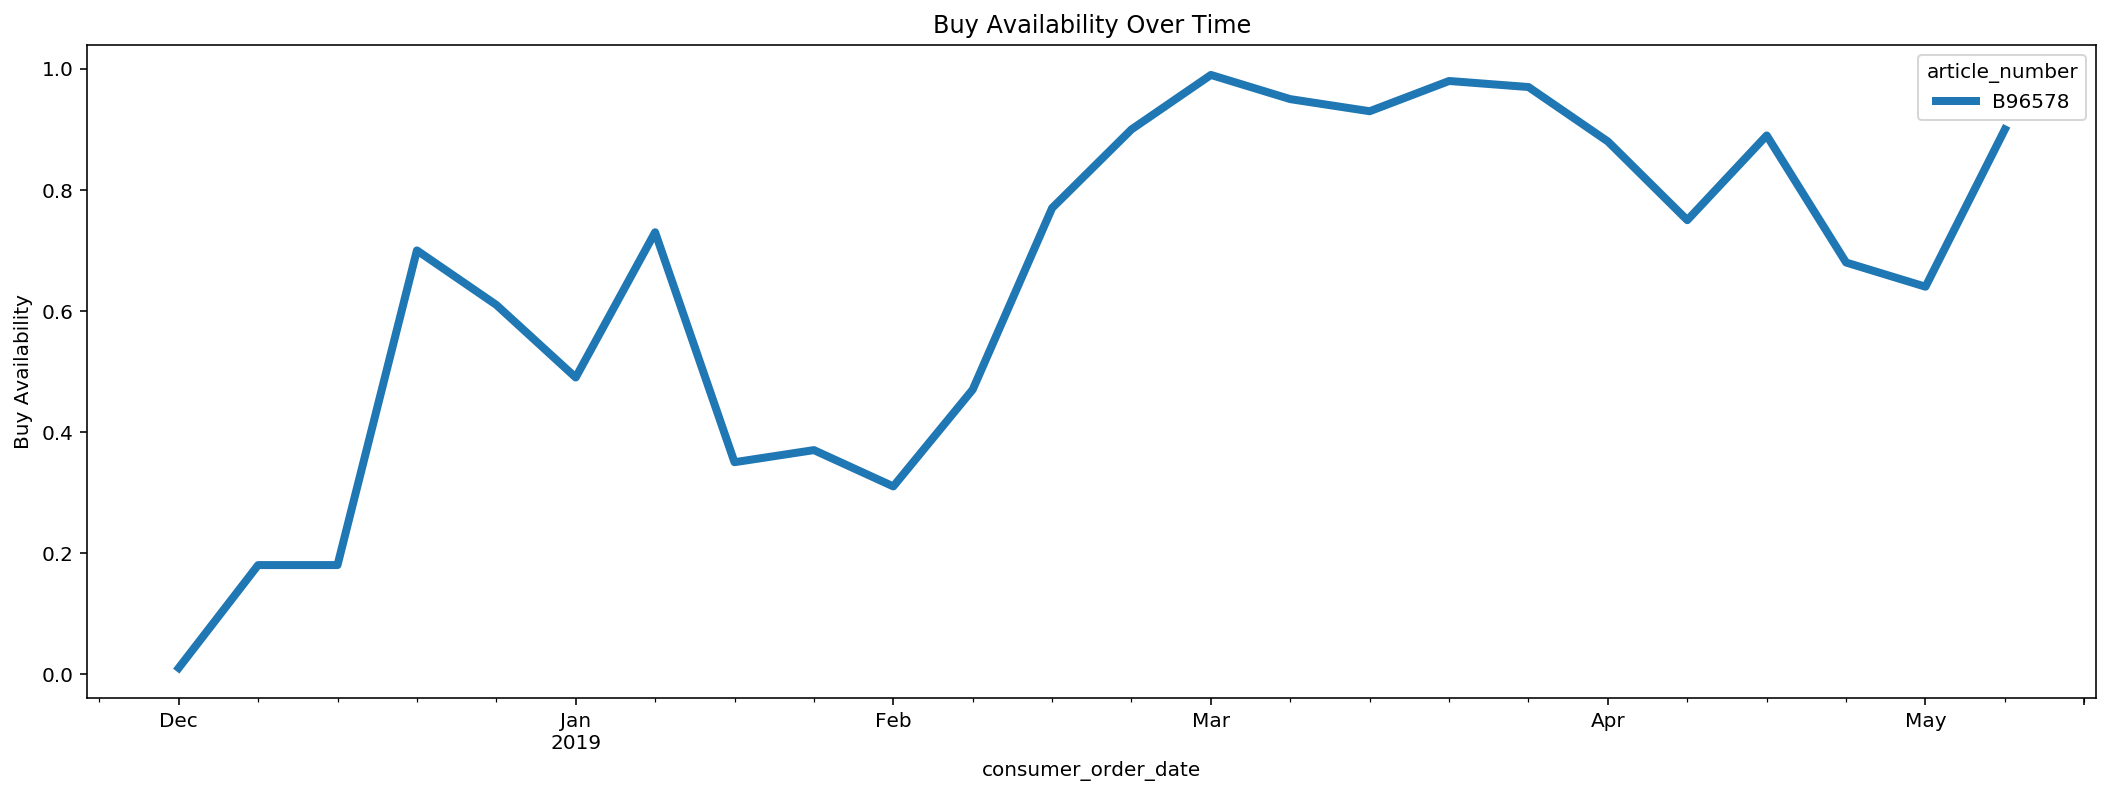

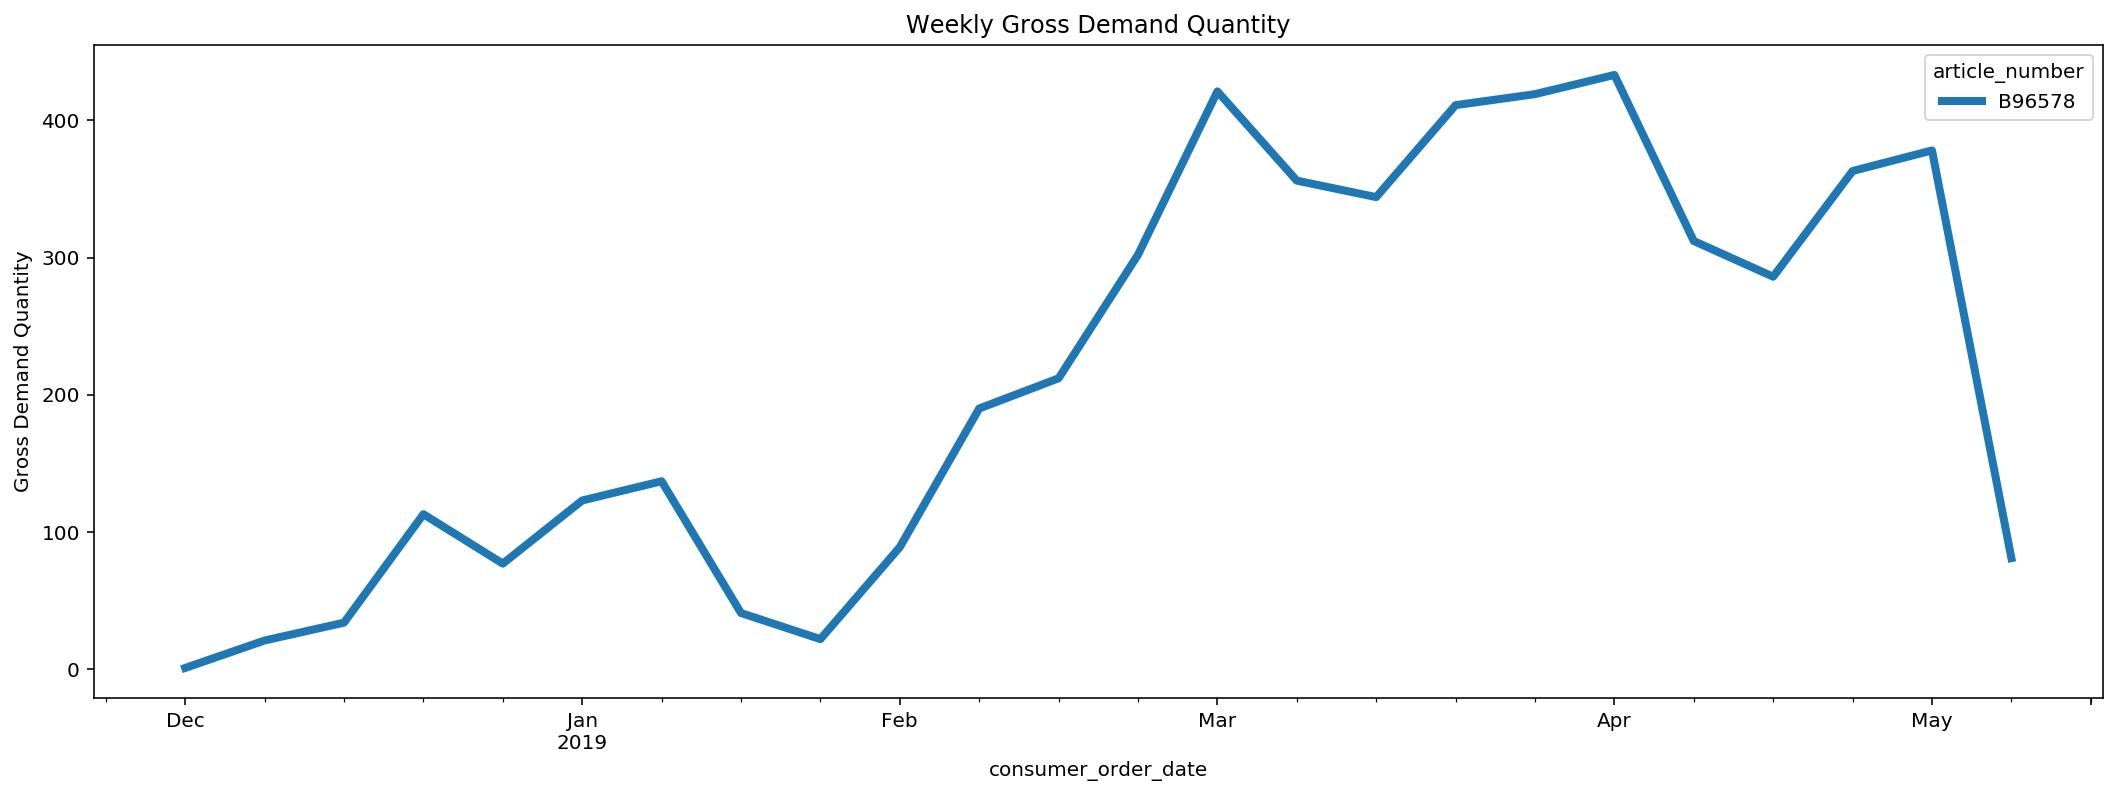

In [32]:
article = 'B96578'
d = dat[dat['article_number'] == article]

pivoted = d.pivot(index = 'consumer_order_date', columns = 'article_number', values = 'buy_availability')

pivoted2 = d.pivot(index = 'consumer_order_date', columns = 'article_number', values = 'gross_demand_quantity')    

forecasts[forecasts.index == article].round()

d.round(2)
d.gross_demand_quantity.sum()

plt.rcParams["figure.figsize"] = [18,6]

pivoted.plot(linewidth = 4)
plt.title('Buy Availability Over Time')
plt.ylabel('Buy Availability')

pivoted2.plot(linewidth = 4)
plt.title('Weekly Gross Demand Quantity')
plt.ylabel('Gross Demand Quantity')

In [29]:
forecasts[(forecasts['Analytics SS20 Net Sales Forecast'] > 5000) &
          (forecasts['Analytics SS20 Net Sales Forecast'] < 10000)]

,eCom SS19 Buy,SS19 Net Qty,SS19 Corrected Net Qty,Analytics SS20 Net Sales Forecast,article_manager,eCom SS20 ILS1 Buy,retail_price,cost,Net Difference-Cost
Article Number,,,,,,,,,
EE8836,3300.0,3311.0,5190.0,5709.0,Thibault,3063.0,100.0,16.0,222264.0
CW1275,13000.0,6520.0,7061.0,7767.1,Anna Triberti,18000.0,70.0,9.0,92096.1
288022,25000.0,6548.0,7093.0,7802.3,Thibault,20000.0,35.0,6.0,73186.2
M20605,8863.0,4966.0,5589.0,6147.9,Ksenia Kotlyarova,5241.0,70.0,12.0,52600.2
BB5478,10500.0,6512.0,7300.0,8030.0,Thibault,7500.0,100.0,15.0,45050.0
CW1203,15000.0,6117.0,6626.0,7288.6,Anna Triberti,18000.0,30.0,4.0,42845.6
DP2398,4651.0,6272.0,6700.0,7370.0,Kristina Linnemeyer,6087.0,40.0,7.0,42339.0
F35543,6000.0,5160.0,5586.0,6144.6,Ksenia Kotlyarova,14027.0,23.0,5.0,39412.0
DV1549,2200.0,5308.0,6266.0,6892.6,Anna Triberti,11000.0,70.0,8.0,32859.2
